In [1]:
#Not all these packages are required but they are here for completeness
import glob
import io
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops
import seaborn as sns
import SimpleITK as sitk
from skimage.color import rgb2hed
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
from skimage import morphology
import time
import warnings

In [2]:
# Import package 

BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.parent.joinpath('HEMnet')

os.chdir(HEMNET_DIR)
from slide import *
from utils import *

In [3]:
# User Input parameters

SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg')

ALIGNMENT_MAG = 2.5
TILE_MAG = 5
VERBOSE = True

In [4]:
# Find Slides

slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
slides

['1820_N_10545A_2_HandE.svs',
 '1820_N_10545A_4_TP53.svs',
 '1820_T_105452F_2_HandE.svs',
 '1820_T_105452F_4_TP53.svs',
 '2065_N_12752A_2_HandE.svs',
 '2065_N_12752A_4_TP53.svs',
 '2065_T_12756A_2_HandE.svs',
 '2065_T_12756A_4_TP53.svs',
 '2112_N_12341B_2_HandE.svs',
 '2112_N_12341B_4_TP53.svs',
 '2112_T_12335F_2_HandE.svs',
 '2112_T_12335F_4_TP53.svs',
 '2148_N_11397A_2_HandE.svs',
 '2148_N_11397A_4_TP53.svs',
 '2148_T_11393A_2_HandE.svs',
 '2148_T_11393A_4_TP53.svs',
 '2171_N_11521A_2_HandE.svs',
 '2171_N_11521A_4_TP53.svs',
 '2171_T_11524A_2_HandE.svs',
 '2171_T_11524A_4_TP53.svs']

In [5]:
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
Paired_slides

[('1820_N_10545A_4_TP53.svs', '1820_N_10545A_2_HandE.svs'),
 ('1820_T_105452F_4_TP53.svs', '1820_T_105452F_2_HandE.svs'),
 ('2065_N_12752A_4_TP53.svs', '2065_N_12752A_2_HandE.svs'),
 ('2065_T_12756A_4_TP53.svs', '2065_T_12756A_2_HandE.svs'),
 ('2112_N_12341B_4_TP53.svs', '2112_N_12341B_2_HandE.svs'),
 ('2112_T_12335F_4_TP53.svs', '2112_T_12335F_2_HandE.svs'),
 ('2148_N_11397A_4_TP53.svs', '2148_N_11397A_2_HandE.svs'),
 ('2148_T_11393A_4_TP53.svs', '2148_T_11393A_2_HandE.svs'),
 ('2171_N_11521A_4_TP53.svs', '2171_N_11521A_2_HandE.svs'),
 ('2171_T_11524A_4_TP53.svs', '2171_T_11524A_2_HandE.svs')]

In [6]:
SLIDE_NUM = 4
PREFIX = Paired_slides[SLIDE_NUM][0][:-7]
print(PREFIX)
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

2112_N_12341B_4_T


In [7]:
def thumbnail(img, size = (1000,1000)):
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail(size)
    return img_thumbnail

In [8]:
he = read_slide_at_mag(he_slide, ALIGNMENT_MAG)
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

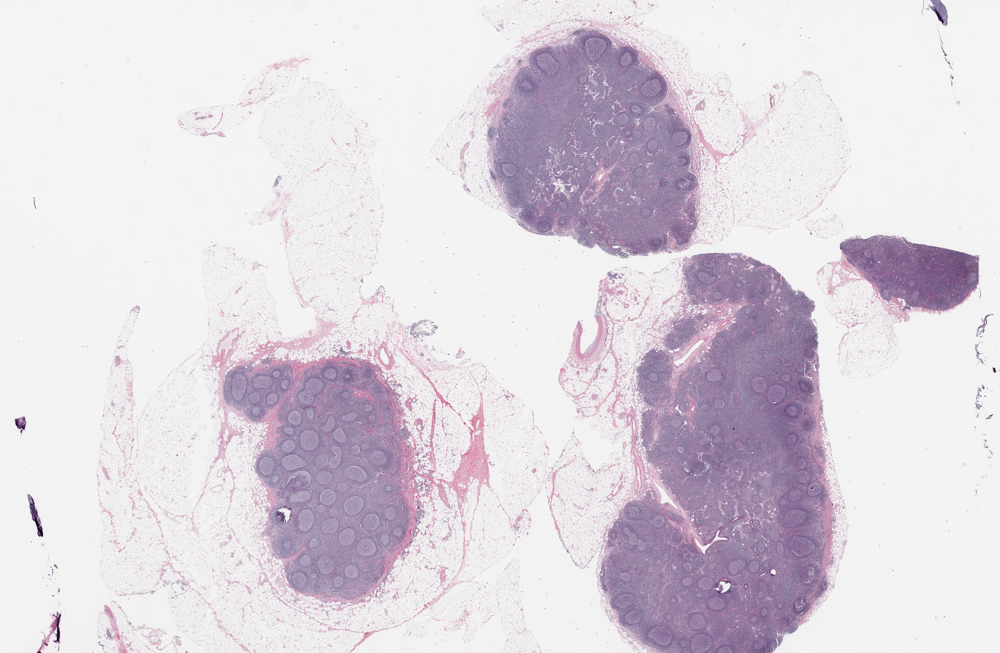

In [9]:
thumbnail(he)

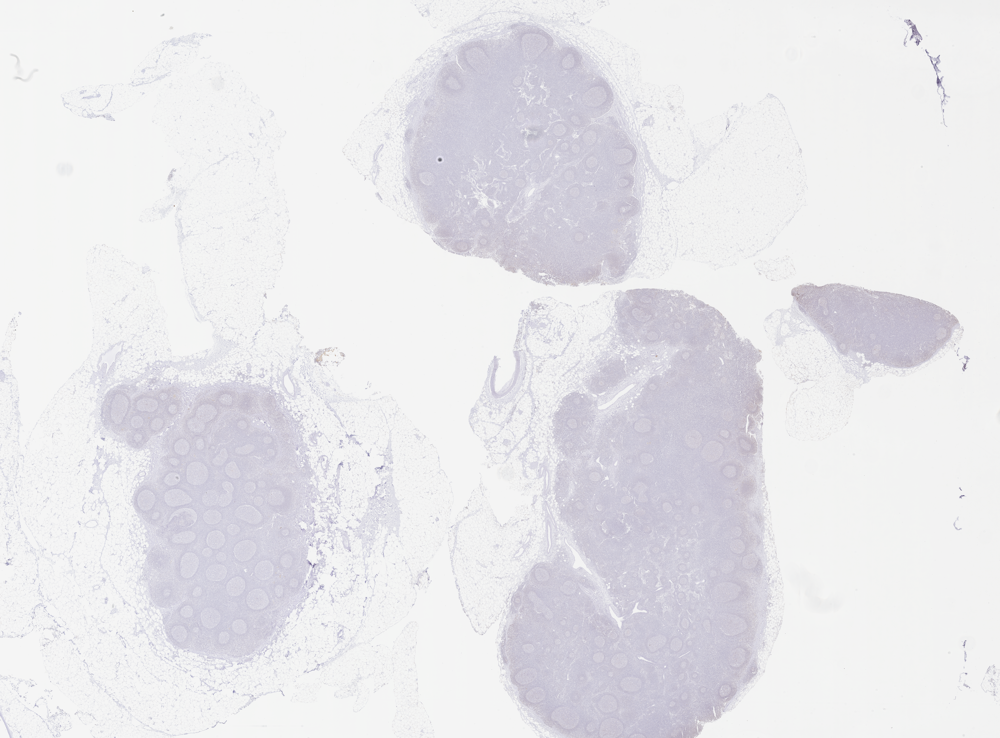

In [10]:
thumbnail(tp53)

In [20]:
#Convert to grayscale
tp53_gray = tp53.convert('L')
he_gray = he.convert('L')
#Convert to ITK format
tp53_itk = get_itk_from_pil(tp53_gray)
he_itk = get_itk_from_pil(he_gray)

In [21]:
def elastix_params():
    a_param_map = sitk.GetDefaultParameterMap('affine')
    a_param_map['MaximumNumberOfIterations'] = ['6000']
    a_param_map['NumberOfSpatialSamples'] = ['100000']
    a_param_map['NumberOfSamplesForExactGradient'] = ['100000']
    b_param_map = sitk.GetDefaultParameterMap('bspline')
    b_param_map['NumberOfResolutions'] = ['7']
    b_param_map['GridSpacingSchedule'] = ['1.0','1.0','1.0','1.0','1.0','1.0','1.0']
    b_param_map['Transform'] = ['RecursiveBSplineTransform']
    b_param_map['MaximumNumberOfIterations'] = ['6000']
    b_param_map['NumberOfSpatialSamples'] = ['100000']
    b_param_map['NumberOfSamplesForExactGradient'] = ['100000']
    b_param_map['FinalGridSpacingInPhysicalUnits'] = ['80000','20000','4960','1280', '320', '80', '20']
    b_param_map['Metric'] = ['NormalizedMutualInformation']   #Faster with unnormalised version
    param_map_vector = sitk.VectorOfParameterMap()
    param_map_vector.append(a_param_map)
    param_map_vector.append(b_param_map)
    return param_map_vector

In [22]:
fixed_img = he_itk
moving_img = tp53_itk
param_map = elastix_params()

In [ ]:
start = time.time()

elastix = sitk.ElastixImageFilter()

elastix.SetFixedImage(fixed_img)
elastix.SetMovingImage(moving_img)
elastix.LogToFileOn()

elastix.SetParameterMap(param_map)
#elastix.LogToConsoleOn()
elastix.Execute()

transform_param_map = elastix.GetTransformParameterMap()

end = time.time()
print(end - start)

In [ ]:
start = time.time()
tp53_aligned = transform_rgb(tp53, transform_param_map)
end = time.time()
print(end - start)

In [ ]:
start = time.time()
tp53_filtered = filter_green(tp53_aligned)
he_filtered = filter_green(he)
green_end = time.time()
tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)
he_filtered = filter_grays(he, tolerance = 15)
gray_end = time.time()
print('Time to Filter Green: {0}'.format(green_end - start))
print('Time to Filter Gray: {0}'.format(gray_end - green_end))

In [ ]:
comparison = show_alignment(he_filtered, tp53_filtered)

In [ ]:
comparison.convert('RGB').save(OUTPUT_PATH.joinpath(PREFIX + 'comparison_norm.jpeg'), 'JPEG')